## Lab 4

### Using the data from following table create a model predicting number of passenger deaths.

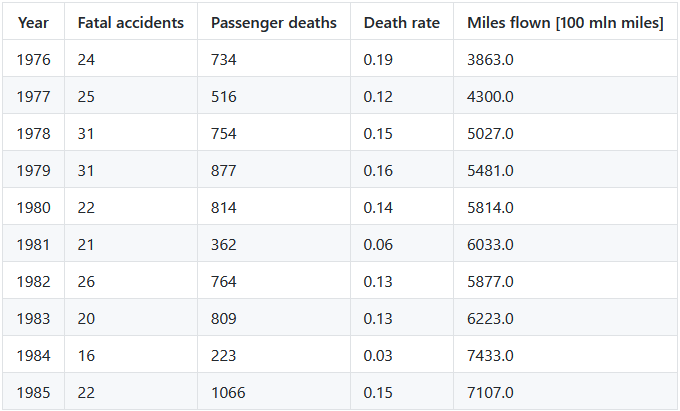

### Use poisson distribution in two variants:
#### 1. The rate is constant for all years and not depending on anything.
#### 2. The intensity is constant, but rate is a product of intensity and miles flown.

### Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

In [13]:
#import and setup statements
import sys
sys.path.append('../')
import pystan
from utility import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [5]:
# Data setup
years = [1976,1977,1978,1979,1980,1981,1982,1983,1984,1985]
fatal_accidents = [24,25,31,31,22,21,26,20,16,22]
passenger_deaths = [734,516,754,877,814,362,764,809,223,1066]
death_rate = [0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]
miles_flown_100mln = [3863.0, 4300.0, 5027.0, 5481.0, 5814.0, 6033.0, 5877.0, 6223.0, 7433.0, 7107.0]

airline_data=pd.DataFrame({'Year':years,
                           'Fatal accidents':fatal_accidents,  
                           'Passenger deaths':passenger_deaths,
                           'Death rate':death_rate,
                           'Miles flown [100 mln miles]':miles_flown_100mln
                          }).set_index('Year')
airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


At that time, the most popular plane in use was the Boeing 747, whose carrying passenger capacity was 467 passengers, with a typical load of 366 passengers in three travel classes per flight (data based on Wikipedia search). Taking into account the fact that new planes with higher capacity were being introduced in the '80s, let's go with an average capacity of <b>420 passengers<b>.

In [8]:
root_of_lam=np.polynomial.polynomial.polyroots([-365.0 * 420.0,3.0,1.0])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[152130.]


### 1. The rate is constant for all years and not depending on anything.

Year
1976     734
1977     516
1978     754
1979     877
1980     814
1981     362
1982     764
1983     809
1984     223
1985    1066
Name: Passenger deaths, dtype: int64
Average number of passenger deaths per year is: 691.9


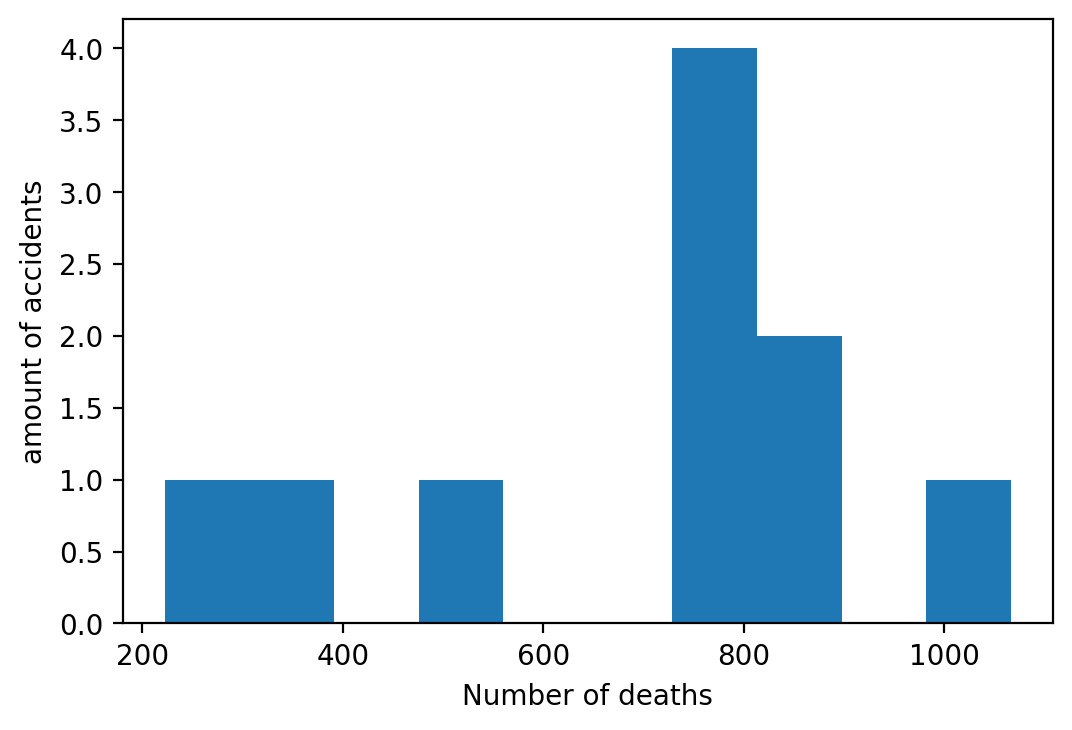

In [12]:
print(airline_data['Passenger deaths'])
plt.hist(airline_data['Passenger deaths'])
plt.xlabel("Number of deaths")
plt.ylabel("amount of accidents")
print('Average number of passenger deaths per year is: {}'.format(airline_data['Passenger deaths'].mean()))

In [28]:
mi = airline_data['Passenger deaths'].mean()
# Now we compile a poisson distribution model with lambda generated of a normal distr N(mi, 180) 
# to catch a wide spectrum since death quantities are scattered all over the place.
# This is a prior predictive check which needs to be performed because we have a narrow spectrum of data (only 10 years).
prior_predictive_checks_model = stan_utility.compile_model('passenger_deaths_ppc.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c0c934d3852d6b54388be9db9175d7b7 NOW.


In [37]:
its=500
samples = prior_predictive_checks_model.sampling(data={},
                                       iter=its,
                                       warmup=0,
                                       refresh=its,
                                       algorithm='Fixed_param',
                                       seed=42)
print(samples)
print(az.summary(samples,var_names=['lambda'], round_to=2, kind='stats'))

Inference for Stan model: anon_model_c0c934d3852d6b54388be9db9175d7b7.
4 chains, each with iter=500; warmup=0; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda    nan     nan    nan  358.3 572.99 691.67 814.44 1023.5    nan    nan
deaths    nan     nan    nan 354.22 568.45  693.0  815.0 1030.6    nan    nan
lp__      0.0     nan    0.0    0.0    0.0    0.0    0.0    0.0    nan    nan

Samples were drawn using Fixed_param at Sat Jun 13 14:19:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
         mean      sd  hpd_3%  hpd_97%
lambda  691.8  175.45  412.69      NaN


In [38]:
samples_params = samples.extract()
samples_lambda = samples_params['lambda']
samples_deaths = samples_params['deaths']

C:\Users\Szczena\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Szczena\anaconda3\envs\py37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


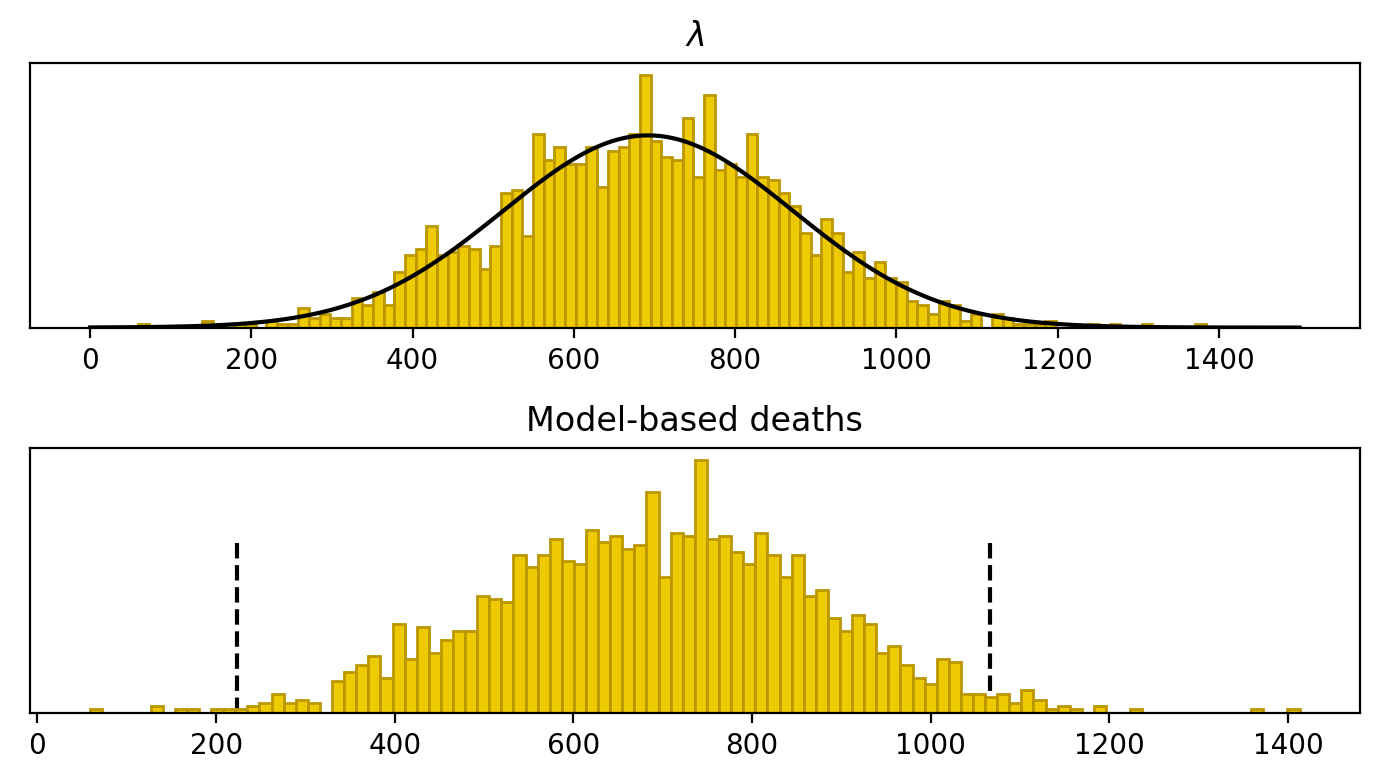

In [39]:
# Let's plot the received values
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(samples_deaths,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([airline_data['Passenger deaths'].min(),airline_data['Passenger deaths'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
ax1.set_title('Model-based deaths')

ax2 = fig.add_subplot(gs[0])
ax2.hist(samples_lambda,bins=100,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=180)
ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax1.set_yticks([])
ax2.set_yticks([])

fig.tight_layout()
plt.show()

In [40]:
# Let's compile a more accurate version of the model
tuned_model = stan_utility.compile_model('passenger_deaths_ppc_tune.stan')

Using cached StanModel


In [41]:
sample_fit=tuned_model.sampling(data={'N':len(airline_data['Passenger deaths']),
                             'deaths':airline_data['Passenger deaths']},
                       seed=42)
print(sample_fit)
print(az.summary(sample_fit,var_names=['lambda'], round_to=2, kind='stats'))

Inference for Stan model: anon_model_f9291cdd08a7ef4eefa4afb8e8b4487f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda 691.74    0.23   8.34 675.55 686.13  691.9 697.39 707.96   1282    1.0
death  692.04    0.47  28.21  639.0  674.0  692.0  710.0  749.0   3543    1.0
lp__    3.8e4    0.02   0.71  3.8e4  3.8e4  3.8e4  3.8e4  3.8e4   1415    1.0

Samples were drawn using NUTS at Sat Jun 13 14:19:48 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
          mean    sd  hpd_3%  hpd_97%
lambda  691.74  8.34  675.54   706.37


With an increased simulated dataset we can now compare the real data with the model data to conclude this experiment.

In [43]:
params_fit=sample_fit.extract()
lambda_fit=params_fit['lambda']
deaths_predicted=params_fit['death']

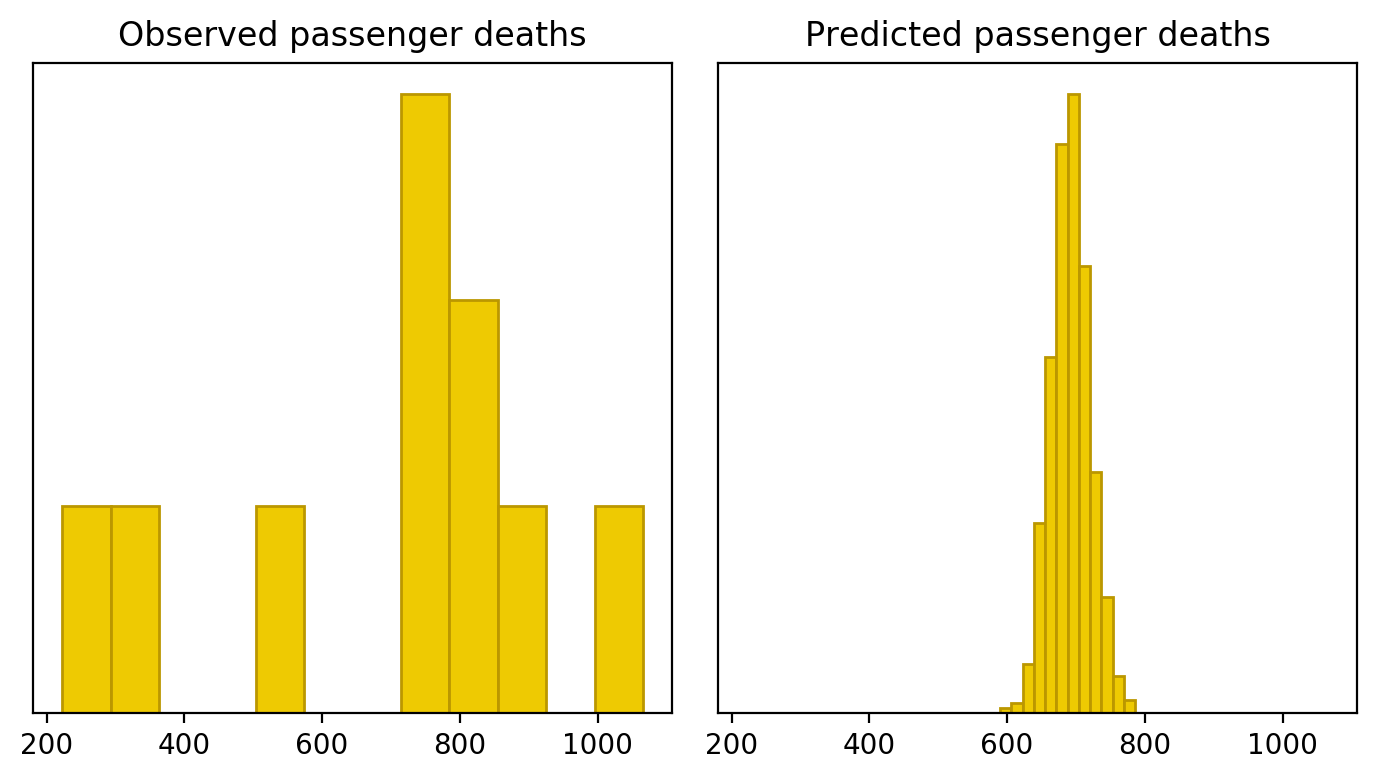

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True)
ax=axes[0]
ax.hist(airline_data['Passenger deaths'],bins=12,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed passenger deaths')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_predicted,bins=12,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted passenger deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

The model somewhat works, but with that low amount of data we cannot really infer anything - fitting a model to 10 points of data can work (poorly, but somewhat work) with any prior. Poisson distribution is, however, a good prior for this case given the rarity of fatal accidents in air-based travel.

### 2. The intensity is constant, but rate is a product of intensity and miles flown.